<div style="text-align: center;">
    <span style="color: #000000; font-size: 30px; font-weight: bold; font-family: Arial; margin: 50px;">
        This is the Python code for the DSA5101 project
    </span>
    <br>
    <span style="color: #000000; font-size: 18px; font-family: Arial;">
        Name: Qin Jiayue<br>
        Student ID: A0294788B
    </span>
</div>


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import time
from sklearn.decomposition import TruncatedSVD
import pickle
from tqdm import tqdm
from funk_svd import SVD
from funk_svd.dataset import fetch_ml_ratings
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# pip install wordcloud

In [25]:
read_path = './data/'
save_path = './temp_results/'

# Dataset Description

## Dataset Overview

In [6]:
# load datasets
ratings_df = pd.read_csv(read_path+'rating.csv')
movies_df = pd.read_csv(read_path+'movie.csv')
ratings_df.head()
movies_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df.describe()
movies_df.describe()

,userId,movieId,rating
count,2.000026e+07,2.000026e+07,2.000026e+07
mean,6.904587e+04,9.041567e+03,3.525529e+00
std,4.003863e+04,1.978948e+04,1.051989e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.439500e+04,9.020000e+02,3.000000e+00
50%,6.914100e+04,2.167000e+03,3.500000e+00
75%,1.036370e+05,4.770000e+03,4.000000e+00
max,1.384930e+05,1.312620e+05,5.000000e+00


,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


The rating is between 0.5 and 5.

In [4]:
ratings_df.info()
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


#### Ratings Dataset (`rating.info()` Output)
- **Dataset Size**: The ratings dataset contains **20,000,263 entries**, meaning there are over 20 million rows of user ratings.
- **Columns**:
  - `userId` (int64): Unique identifier for each user who provided a rating.
  - `movieId` (int64): Unique identifier for each movie that was rated.
  - `rating` (float64): Rating score provided by users, represented as a floating-point number.
  - `timestamp` (object): The time at which each rating was provided, stored as an object (likely representing a timestamp format).
- **Memory Usage**: Approximately **610.4 MB**.


#### Movies Dataset (`movie.info()` Output)
- **Dataset Size**: The movies dataset contains **27,278 entries**, indicating it includes information on over 27,000 movies.
- **Columns**:
  - `movieId` (int64): Unique identifier for each movie, which matches with the `movieId` in the ratings dataset.
  - `title` (object): The title of the movie.
  - `genres` (object): The genre(s) associated with each movie, stored as a string format (e.g., "Action|Adventure|Sci-Fi" for multiple genres).
- **Memory Usage**: Approximately **639.5 KB**, which is significantly smaller than the ratings dataset.


#### Observations
- Both datasets share the `movieId` column, which will allow us to merge them for combined analyses.
- The `timestamp` in the ratings dataset may need to be converted from an object to a datetime format for time-based analysis or feature engineering, like identifying rating trends over time.

In [5]:
# Check for missing values
ratings_missing = ratings_df.isnull().sum()
movies_missing = movies_df.isnull().sum()

print("Missing values in Ratings dataset:")
print(ratings_missing)
print("\nMissing values in Movies dataset:")
print(movies_missing)

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64


Therefore, there is no missing value.

In [9]:
# Count unique movieId values in each dataset
unique_movieId_ratings = ratings_df['movieId'].nunique()
unique_movieId_movies = movies_df['movieId'].nunique()

print("\nUnique movieId count in Ratings dataset:", unique_movieId_ratings)
print("Unique movieId count in Movies dataset:", unique_movieId_movies)

# Count unique userId values in the Ratings dataset
unique_userId_ratings = ratings_df['userId'].nunique()

print("\nUnique userId count in Ratings dataset:", unique_userId_ratings)


Unique movieId count in Ratings dataset: 26744
Unique movieId count in Movies dataset: 27278

Unique userId count in Ratings dataset: 138493


#### Unique `movieId` Count
- The `movieId` column represents unique movie identifiers.
- **Ratings Dataset**: There are **26,744 unique movie IDs**, which suggests that some movies are rated by multiple users.
- **Movies Dataset**: There are **27,278 unique movie IDs**, which is slightly higher than in the ratings dataset. 
  - **Observation**: Some movies in the `movies` dataset may not have any ratings in the `ratings` dataset. This is common in recommendation datasets where not all items receive user interactions.

#### Unique `userId` Count in Ratings Dataset
- The `userId` column represents unique users who provided ratings.
- **Result**: There are **138,493 unique users** in the ratings dataset.

In [10]:
# Calculate the number of movies each user has rated
user_movie_counts = ratings_df.groupby('userId')['movieId'].nunique()

# Calculate the number of users who have rated each movie
movie_user_counts = ratings_df.groupby('movieId')['userId'].nunique()

# Get the maximum and minimum number of movies rated by a user
user_max_movies = user_movie_counts.max()
user_min_movies = user_movie_counts.min()

# Get the maximum and minimum number of users who rated each movie
movie_max_users = movie_user_counts.max()
movie_min_users = movie_user_counts.min()

# Print the results
print("Maximum number of movies rated by a user:", user_max_movies)
print("Minimum number of movies rated by a user:", user_min_movies)
print("Maximum number of users who rated a movie:", movie_max_users)
print("Minimum number of users who rated a movie:", movie_min_users)


Maximum number of movies rated by a user: 9254
Minimum number of movies rated by a user: 20
Maximum number of users who rated a movie: 67310
Minimum number of users who rated a movie: 1


<Figure size 1008x576 with 0 Axes>

<BarContainer object of 26744 artists>

Text(0.5, 0, 'Average Movie Rating (Higher on the Left)')

Text(0, 0.5, 'Number of Ratings per Movie')

Text(0.5, 1.0, 'Number of Ratings per Movie vs. Average Movie Rating')

(array([0., 1., 2., 3., 4., 5., 6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

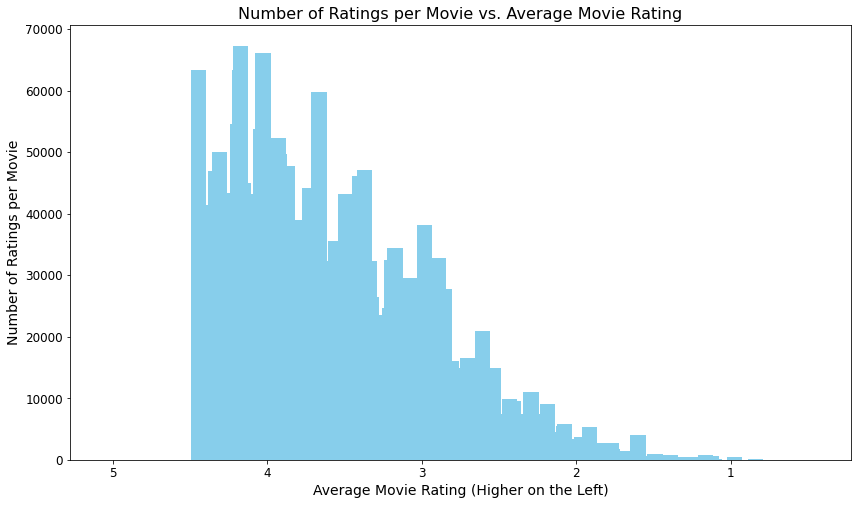

In [7]:
# Calculate the average rating and the number of ratings for each movie
movie_rating_stats = ratings_df.groupby('movieId').agg(
    average_rating=('rating', 'mean'),  # Calculate average rating
    rating_count=('rating', 'count')    # Calculate rating count
).reset_index()

# Sort by average rating in descending order
movie_rating_stats = movie_rating_stats.sort_values(by='average_rating', ascending=False)

# Plot the bar chart
plt.figure(figsize=(14, 8))
plt.bar(movie_rating_stats['average_rating'], movie_rating_stats['rating_count'], width=0.1, color='skyblue')
plt.xlabel("Average Movie Rating (Higher on the Left)", fontsize=14)  # Adjust font size for x-axis label
plt.ylabel("Number of Ratings per Movie", fontsize=14)               # Adjust font size for y-axis label
plt.title("Number of Ratings per Movie vs. Average Movie Rating", fontsize=16)  # Adjust font size for title
plt.xticks(fontsize=12)  # Adjust font size for x-ticks
plt.yticks(fontsize=12)  # Adjust font size for y-ticks
plt.gca().invert_xaxis()  # Reverse x-axis to display from high to low
plt.show()


#### Observations
- **X-Axis (Average Movie Rating)**: Movies are sorted by their average rating, with higher-rated movies on the left side and lower-rated movies on the right. This arrangement provides insight into how the popularity (measured by rating count) varies with average rating.
- **Y-Axis (Number of Ratings per Movie)**: The vertical axis shows the number of users who rated each movie.

#### Insights
- **Long-Tail Distribution**: We observe a long-tail distribution, where movies with high average ratings generally receive more ratings, while movies with lower ratings tend to have fewer interactions. This is typical in movie datasets, where popular movies accumulate more ratings.
- **High Rating Cluster**: A notable number of movies have average ratings above 4, indicating that users tend to rate popular movies more favorably.
- **Low Rating and Low Interaction**: Movies with low average ratings generally have fewer ratings, highlighting potential "cold start" items which may need special attention in recommendation systems.

By examining this plot, we gain insights into the data distribution that can guide our approach in building and optimizing recommendation models.

<Figure size 1600x800 with 0 Axes>

(-0.5, 3999.5, 1999.5, -0.5)

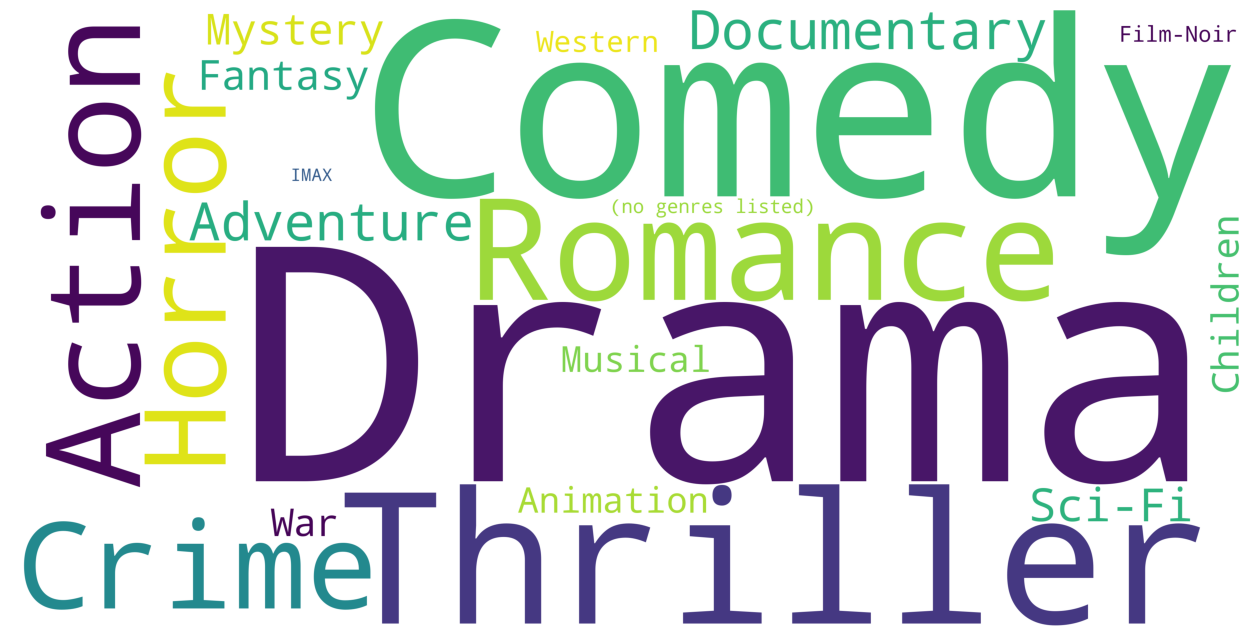

In [3]:
# Process the genres field to generate a word cloud for genres
# Split the genres by '|' to create a large list, then count the frequency of each genre

movies_df['genres'] = movies_df['genres'].fillna("").astype('str')
all_genres = movies_df['genres'].str.split('|').sum()
genre_counts = pd.Series(all_genres).value_counts()
genre_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate_from_frequencies(genre_counts)

# Plot the word cloud
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()


#### Word Cloud Observations
- **Popular Genres**: Genres like "Drama," "Comedy," and "Thriller" appear larger, indicating they are common in the dataset.
- **Less Frequent Genres**: Smaller genres, such as "Film-Noir" and "Western," suggest they are less common.

In [5]:
# Calculate the average rating for each movie
movie_ratings = ratings_df.groupby('movieId').agg(average_rating=('rating', 'mean')).reset_index()

# Merge with the movies DataFrame to get movie titles
top_rated_movies = movie_ratings.merge(movies_df[['movieId', 'title']], on='movieId')

# Sort by average rating in descending order and select the top 10
top_5_movies = top_rated_movies.sort_values(by='average_rating', ascending=False).head(10)

# Output the titles of the top 10 highest-rated movies
print("Top 5 Highest-Rated Movies:")
print(top_5_movies[['title', 'average_rating']])


Top 5 Highest-Rated Movies:
                                                title  average_rating
19152               Barchester Chronicles, The (1982)             5.0
21842                            Only Daughter (2013)             5.0
17703                            Boys (Drenge) (1977)             5.0
21656                       Linotype: The Film (2012)             5.0
21658                             Rocaterrania (2009)             5.0
17556             Summer Wishes, Winter Dreams (1973)             5.0
25936                              Small Roads (2011)             5.0
21762  Year Zero: The Silent Death of Cambodia (1979)             5.0
21763                        Stealing a Nation (2004)             5.0
21840                                   B-Side (2013)             5.0


<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='rating', ylabel='Density'>

Text(0.5, 1.0, 'Ratings per User for MovieLens Dataset')

Text(0.5, 0, 'Number of Ratings per User')

Text(0, 0.5, 'Proportion')

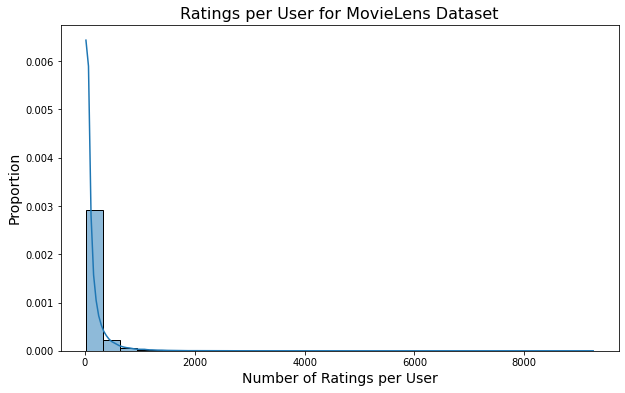

In [11]:
# Ratings per user for MovieLens dataset
ratings_per_user = ratings_df.groupby('userId')['rating'].count()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True, stat="density")  # Use density to show proportions
plt.title("Ratings per User for MovieLens Dataset", fontsize=16)
plt.xlabel("Number of Ratings per User", fontsize=14)
plt.ylabel("Proportion", fontsize=14)  # Change label to indicate proportion
plt.show()


#### Observations
- **Skewed Distribution**: The histogram reveals a highly skewed distribution, with most users providing relatively few ratings, while a small number of users have rated hundreds or even thousands of movies.
- **High Frequency at Low Counts**: The majority of users have rated fewer than 100 movies, indicating that most users interact with the platform on an occasional basis.


## Data Processing

Distribution of ratings per user in the sampled data:
count    10000.000000
mean       436.512100
std        527.207109
min         20.000000
25%        109.000000
50%        259.000000
75%        561.250000
max       9254.000000
dtype: float64


<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 0, 'Number of Ratings per User')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Ratings per User for Sampled MovieLens Dataset (10,000 users)')

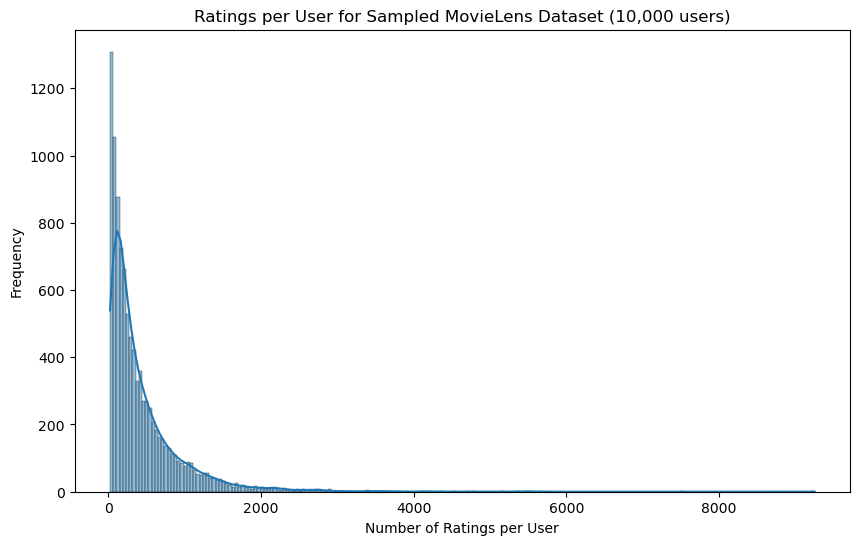

In [7]:
# Calculate the number of ratings each user has given
user_rating_counts = ratings_df.groupby('userId').size()

# Define the sample size
sample_size = 10000

# Sample users while keeping the original distribution
# Use `sample` with `weights` based on the distribution of user rating counts
sampled_users = user_rating_counts.sample(n=sample_size, weights=user_rating_counts, random_state=42)

# Filter the original ratings DataFrame to include only the sampled users
sampled_ratings_df = ratings_df[ratings_df['userId'].isin(sampled_users.index)]

# Check the distribution of the sampled data
print("Distribution of ratings per user in the sampled data:")
print(sampled_ratings_df.groupby('userId').size().describe())

# Display a histogram to verify the distribution preservation

plt.figure(figsize=(10, 6))
sns.histplot(sampled_ratings_df.groupby('userId').size(), kde=True)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.title("Ratings per User for Sampled MovieLens Dataset (10,000 users)")
plt.show()


In [9]:
sampled_user_data = pd.merge(sampled_ratings_df, movies_df, on='movieId', how='left')

# Function to extract year from the title
def extract_year(title):
    # Search for a year pattern (4 digits) within parentheses
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

sampled_user_data['year'] = sampled_user_data['title'].apply(extract_year)

sampled_user_data.to_csv(save_path+"sampled_user_data_20241108.csv", index=False)

In [10]:
sampled_user_data.head()

,userId,movieId,rating,timestamp,title,genres,year
0,2,3,4.0,2000-11-21 15:34:49,Grumpier Old Men (1995),Comedy|Romance,1995.0
1,2,62,5.0,2000-11-21 15:29:58,Mr. Holland's Opus (1995),Drama,1995.0
2,2,70,5.0,2000-11-21 15:31:31,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller,1996.0
3,2,110,4.0,2000-11-21 15:30:58,Braveheart (1995),Action|Drama|War,1995.0
4,2,242,3.0,2000-11-21 15:32:56,Farinelli: il castrato (1994),Drama|Musical,1994.0


In [23]:
# Calculate the number of movies each user has rated
user_movie_counts = sampled_user_data.groupby('userId')['movieId'].nunique()

# Calculate the number of users who have rated each movie
movie_user_counts = sampled_user_data.groupby('movieId')['userId'].nunique()

# Get the maximum and minimum number of movies rated by a user
user_max_movies = user_movie_counts.max()
user_min_movies = user_movie_counts.min()

# Get the maximum and minimum number of users who rated each movie
movie_max_users = movie_user_counts.max()
movie_min_users = movie_user_counts.min()

# Print the results
print("Maximum number of movies rated by a user:", user_max_movies)
print("Minimum number of movies rated by a user:", user_min_movies)
print("Maximum number of users who rated a movie:", movie_max_users)
print("Minimum number of users who rated a movie:", movie_min_users)

Maximum number of movies rated by a user: 9254
Minimum number of movies rated by a user: 20
Maximum number of users who rated a movie: 7167
Minimum number of users who rated a movie: 1


## Visualization

In [13]:
sampled_user_data = pd.read_csv(read_path+"sampled_user_data_20241108.csv")

In [14]:
sampled_user_data.shape

(4365121, 7)

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Rating Distribution for the Sampled MovieLens Data')

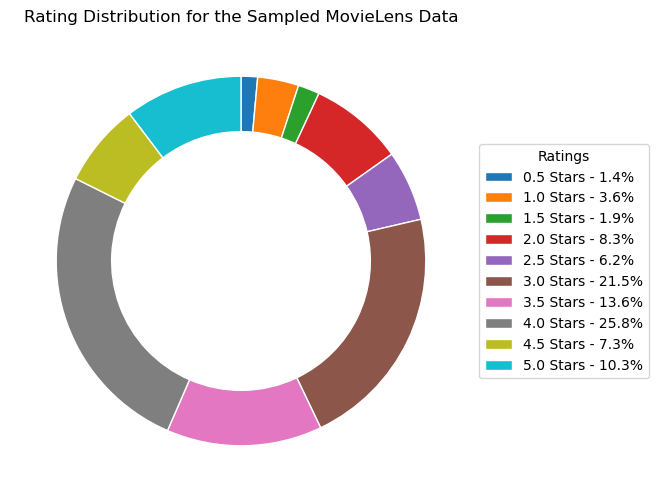

In [13]:
# Plot the Donut Chart

# Step 1: Calculate the count of each rating
rating_counts = sampled_user_data['rating'].value_counts().sort_index()

# Step 2: Calculate the percentage of each rating
rating_percentages = rating_counts / rating_counts.sum() * 100

# Step 3: Plot the donut chart without labels on the wedges
plt.figure(figsize=(8, 6))
wedges, _ = plt.pie(rating_percentages, startangle=90, counterclock=False, 
                    wedgeprops=dict(width=0.3, edgecolor='w'), 
                    autopct=None)

# Step 4: Add legend with rating and percentage information
labels = [f"{rating} Stars - {percentage:.1f}%" for rating, percentage in zip(rating_percentages.index, rating_percentages)]
plt.legend(wedges, labels, title="Ratings", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add title
plt.title("Rating Distribution for the Sampled MovieLens Data")

# Display the plot
plt.show()


<Figure size 576x432 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Rating Frequency for Sampled Users')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Frequency')

([<matplotlib.axis.XTick at 0x24f66459ac8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

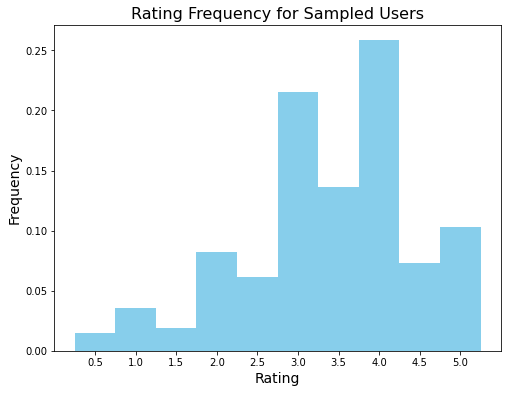

In [15]:
# Calculate the frequency of each rating
rating_counts = sampled_user_data['rating'].value_counts(normalize=True).sort_index()

# Set up the figure layout and add spacing
plt.figure(figsize=(8, 6))

# Plot a bar chart of rating frequencies for active users
plt.bar(rating_counts.index, rating_counts.values, color='skyblue', width=0.5)
plt.title("Rating Frequency for Sampled Users", fontsize=16)
plt.xlabel("Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rating_counts.index)  # Set x-axis ticks to rating values

plt.show()


The bar chart above illustrates the frequency distribution of movie ratings given by the sampled users in the dataset. This visualization helps us understand the overall sentiment and distribution of ratings in our sample.

#### Observations
- **Common Ratings**: The most frequent rating given by users is around 4.0, indicating that users tend to give higher ratings on average.
- **Lower Ratings**: Ratings below 2.0 are relatively rare, suggesting that users are less likely to rate movies negatively.

Therefore, it is necessary to carry out averaging when rating is used to calculate similarity


# Content-based Recommendation Algorithm

In [1]:
# load data
sampled_user_data = pd.read_csv(read_path+'sampled_user_data_20241108.csv')
sampled_user_data.head()

**Step: Generating Item Profiles Based on Genre Frequency for Similarity Calculation**

In this step, we generate **item profiles** for each movie based on the frequency of genres, which will allow us to calculate similarity between movies.

1. Using the `genres` column, we compute the frequency of each genre for all movies. By transforming the genre data into a frequency-based item profile matrix, we can represent each movie as a vector of genre-related terms. This structure enables efficient calculation of movie similarity based on genre features.
   
2. **Pre-calculating Movie Similarities**: To improve computational efficiency, we precompute the similarity between all movies using these item profiles. This precomputed similarity matrix will allow us to retrieve movie similarity scores quickly, avoiding redundant calculations during recommendations.

This item profile matrix, stored as a `.pkl` file, provides a foundation for content-based recommendations by capturing the genre characteristics of each movie and enabling efficient similarity lookup.


In [ ]:
def generate_item_profiles(user_data):
    """
    Generate item profiles based on genres information for movies in a user data DataFrame.

    Parameters:
    - user_data (DataFrame): The DataFrame containing user movie ratings with columns 'movieId', 'title', and 'genres'.
                             Each movie is associated with a specific genre in the 'genres' column.
    - save_path (str): The directory path where the resulting item profiles DataFrame should be saved.
    - file_name (str): The name of the file to save the item profiles as a .pkl file. Default is "item_profiles.pkl".

    Returns:
    - item_profiles (DataFrame): A DataFrame representing the item profile for each movie. Rows are indexed by movieId,
                                 and columns represent different genre n-grams (single words and pairs of words).
    """

    # Step 1: Remove duplicates to keep unique combinations of (movieId, title, genres)
    unique_movies = user_data[['movieId', 'title', 'genres']].drop_duplicates()

    # Step 2: Replace '|' with spaces in the genres column for CountVectorizer compatibility
    unique_movies['genres'] = unique_movies['genres'].str.replace('|', ' ')

    # Step 3: Use CountVectorizer to process genres and generate item profile matrix
    cv = CountVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
    count_matrix = cv.fit_transform(unique_movies['genres'])

    # Step 4: Convert the item profile matrix to a DataFrame with movieId as the index
    item_profiles = pd.DataFrame(count_matrix.toarray(), index=unique_movies['movieId'].unique())


    # Print the shape of the item profile matrix
    print(f"Item profile matrix shape: {item_profiles.shape}")

    # Return the item profile DataFrame
    return item_profiles

sampled_user_item_profiles = generate_item_profiles(sampled_user_data)
pickle.dump(sampled_user_item_profiles, open(save_path + 'sampled_CB_item_profiles_genres_20241109.pkl', 'wb'))

**Step: Below code implements a content-based recommendation system by generating user profiles based on movie genres and recommending similar items. Below is an explanation of each function and its role in the recommendation pipeline:**

1. `generate_user_profile(user_data, item_profiles)`
This function generates a **user profile** for each user by calculating a weighted average of genre features from the movies they have rated. The key steps include:
   - **Calculate Rating Deviations**: For each movie rated by the user, the rating is adjusted by subtracting the user's average rating to capture user preference relative to their baseline.
   - **Aggregate Genre Features**: The adjusted ratings are used as weights to aggregate genre features from `item_profiles`.
   - **Normalization**: The aggregated profile is normalized by the number of rated movies, resulting in a user profile that represents their genre preferences.

Each user profile is stored in a dictionary with the user ID as the key and the profile vector as the value.

2. `recommend_top_k(user_id, user_profiles, item_profiles, train_data, k=20)`
This function recommends the top `k` movies for a specified user by comparing their profile with all item profiles using **cosine similarity**. The process includes:
   - **Filter Rated Movies**: Exclude movies the user has already rated to avoid redundant recommendations.
   - **Calculate Similarities**: Compute cosine similarity between the user profile and each unrated movie profile.
   - **Select Top-K Recommendations**: Identify and return the top `k` most similar movies as recommendations.

3. `split_train_test_by_user(data, k=1)`
This function splits the dataset into **training and testing sets** for each user by selecting each user's last `k` ratings as the test set and using the rest as the training set. Key steps:
   - **Sort by Timestamp**: Ensures that the test set contains the most recent interactions.
   - **Split by User**: Extracts the last `k` ratings for each user and separates the remaining ratings as training data.

This setup helps in evaluating the recommendation system by simulating real-world usage.

4. `evaluate_hit_rate_at_k(test_data, recommendations, k=20)`
This function evaluates the recommendations using **Hit Rate@K**, which measures the proportion of users for whom at least one relevant item appears in the top `k` recommendations. The process involves:
   - **Identify Relevant Items**: For each user, retrieve movies they rated in the test set.
   - **Check for Hits**: Count users for whom at least one movie in the top `k` recommendations matches the test set.
   - **Calculate Hit Rate**: Compute the hit rate as the ratio of users with at least one hit.

This metric gives a sense of how often the recommendation system successfully identifies relevant items for users.

5. `run_content_based_experiment(user_data, item_profile_file, label, num_samples=10, sample_size=5000, k=20, save_path='./tmp_results/')`
This function orchestrates the entire recommendation experiment, sampling users, generating recommendations, and evaluating the system’s performance. Steps include:
   - **Load Item Profiles**: Load precomputed item profiles from a specified file.
   - **Sampling Users**: Randomly select a subset of users for each experiment iteration.
   - **Data Filtering**: Filter item profiles based on movies released within the timeframe of sampled user ratings to ensure relevance.
   - **Generate Recommendations**: For each sampled user, recommend top `k` movies using the `recommend_top_k` function.
   - **Evaluate Performance**: Measure the Hit Rate@K for each sample and record the time taken.

The results are stored in a DataFrame, capturing hit rates and runtime for each sample iteration, which can be analyzed to assess the recommendation system’s effectiveness.


In [ ]:
# Function to generate user profiles based on user ratings and item profiles
def generate_user_profile(user_data, item_profiles, user_id_col='userId', movie_id_col='movieId', rating_col='rating'):
    """
    Generate a user profile by calculating weighted average genre features for each user.

    Parameters:
    - user_data (DataFrame): The DataFrame containing user ratings with columns 'userId', 'movieId', and 'rating'.
    - item_profiles (DataFrame): The DataFrame containing item profiles with genre-related features for each movie.
    - user_id_col (str): Column name for user IDs.
    - movie_id_col (str): Column name for movie IDs.
    - rating_col (str): Column name for ratings.

    Returns:
    - user_profiles (dict): A dictionary where each key is a user ID, and each value is the user's profile vector.
    """
    
    def calculate_single_user_profile(user_id):
        # Get all ratings for the specified user
        user_ratings = user_data[user_data[user_id_col] == user_id]
        # Initialize an empty profile vector with the same number of dimensions as the item profile features
        profile = np.zeros(item_profiles.shape[1])
        # Calculate the mean rating for the user
        mean_rating = user_ratings[rating_col].mean()
        # Count the number of unique movies rated by the user
        movie_count = user_ratings[movie_id_col].nunique()

        # Update the profile vector based on each rated movie
        for _, row in user_ratings.iterrows():
            movie_id = row[movie_id_col]
            rating = row[rating_col]
            if movie_id in item_profiles.index:
                # Weight each item's genre features by the user's rating deviation from their mean
                profile += (rating - mean_rating) * item_profiles.loc[movie_id].values

        # Normalize the profile vector by dividing by the number of movies rated (plus a small epsilon to avoid division by zero)
        return profile / (movie_count + 1e-10)

    # Generate profiles for all unique users
    return {
        user_id: calculate_single_user_profile(user_id)
        for user_id in tqdm(user_data[user_id_col].unique(), desc="Generating user profiles")
    }

# Function to recommend top-k items for a specific user based on content similarity
def recommend_top_k(user_id, user_profiles, item_profiles, train_data, k=20):
    """
    Recommend top-k items for a user based on cosine similarity between user profile and item profiles.

    Parameters:
    - user_id (int): The ID of the user to recommend items for.
    - user_profiles (dict): Dictionary of user profiles.
    - item_profiles (DataFrame): DataFrame of item profiles with genre features.
    - train_data (DataFrame): Training data containing user-item interactions.
    - k (int): Number of top recommendations to return.

    Returns:
    - list: List of recommended movie IDs.
    """
    user_profile = user_profiles.get(user_id)
    if user_profile is None:
        return []

    # Calculate cosine similarity between the user's profile and all item profiles
    similarity_scores = cosine_similarity([user_profile], item_profiles.values).flatten()
    # Get movie IDs that the user has already rated
    rated_movie_ids = train_data[train_data['userId'] == user_id]['movieId'].unique()
    all_movie_ids = set(item_profiles.index)
    # Identify unrated movie IDs
    unrated_movie_ids = list(all_movie_ids - set(rated_movie_ids))

    # Get similarity scores for unrated movies
    unrated_indices = [item_profiles.index.get_loc(movie_id) for movie_id in unrated_movie_ids]
    unrated_similarities = similarity_scores[unrated_indices]

    # Find the indices of the top-k recommended movies
    top_k_indices = np.argsort(unrated_similarities)[-k:][::-1]
    return [unrated_movie_ids[i] for i in top_k_indices]

# Function to split data into training and testing sets for each user
def split_train_test_by_user(data, k=1):
    """
    Splits the data into training and testing sets for each user.
    Each user's last `k` ratings are used for the test set, and the rest are for the training set.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing user ratings with columns 'userId', 'movieId', 'rating', and 'timestamp'.
    - k (int): Number of last ratings per user to use as the test set.

    Returns:
    - train_data (pd.DataFrame): The training set containing all but the last `k` ratings for each user.
    - test_data (pd.DataFrame): The test set containing the last `k` ratings for each user.
    """
    # Sort data by user and timestamp to ensure the last `k` ratings are the most recent
    data = data.sort_values(['userId', 'timestamp']).reset_index(drop=True)

    # Separate the last `k` ratings for each user
    test_data = data.groupby('userId').tail(k)
    train_data = data.drop(test_data.index)

    return train_data, test_data

# Evaluation function to compute Hit Rate@K
def evaluate_hit_rate_at_k(test_data, recommendations, k=20):
    """
    Evaluates the recommendation results using Hit Rate@K.
    
    Parameters:
    - test_data (DataFrame): DataFrame containing the test data with actual user-item interactions.
    - recommendations (dict): Dictionary containing recommended items per user.
    - k (int): Number of recommendations considered for evaluation.
    
    Returns:
    - hit_rate (float): Proportion of users for whom at least one relevant item is recommended.
    """
    hits = 0  # Count users with at least one hit

    for user_id, recommended_movies in recommendations.items():
        # Retrieve relevant items (items rated by the user in the test set)
        relevant_movies = test_data[test_data['userId'] == user_id]['movieId'].unique()
        
        # Check if there is at least one hit in the recommended movies
        if len(set(recommended_movies) & set(relevant_movies)) > 0:
            hits += 1

    # Calculate Hit Rate as the proportion of users with at least one hit
    hit_rate = hits / len(recommendations) if len(recommendations) > 0 else 0
    return hit_rate

# Modified function for user sampling, recommendation, and evaluation
def run_content_based_experiment(user_data, item_profile_file, label, num_samples=10, sample_size=5000, k=20):
    """
    Runs a content-based recommendation experiment by sampling users, generating recommendations,
    and evaluating them using Hit Rate@K.
    
    Parameters:
    - user_data (DataFrame): Dataset containing user ratings.
    - item_profile_file (str): Filename of the item profile file to load.
    - label (str): Label to identify the experiment.
    - num_samples (int): Number of samples to draw.
    - sample_size (int): Number of users to sample per iteration.
    - k (int): Number of recommendations to generate per user.
    
    Returns:
    - results (DataFrame): DataFrame containing hit rate and time taken for each sample.
    """
    # Load item profiles
    item_profiles = pickle.load(open(save_path + item_profile_file, 'rb'))
    results = []

    for i in range(num_samples):
        # Sample users
        sampled_users = user_data['userId'].drop_duplicates().sample(sample_size, random_state=i)
        sampled_data = user_data[user_data['userId'].isin(sampled_users)]
        
        # Filter item profiles based on movie release date within the sampled users' rating period
        sampled_data['timestamp'] = pd.to_datetime(sampled_data['timestamp'])
        sampled_data['year'] = pd.to_datetime(sampled_data['year'], format='%Y')
        max_timestamp = sampled_data['timestamp'].max()
        filtered_item_profiles = item_profiles[item_profiles.index.isin(
            sampled_data[sampled_data['year'] <= max_timestamp]['movieId'].unique()
        )]

        # Split data into training and testing sets
        train_data, test_data = split_train_test_by_user(sampled_data, k=1)
        
        # Generate user profiles
        user_profiles = generate_user_profile(train_data, filtered_item_profiles)

        # Generate recommendations and record time taken
        test_user_ids = test_data['userId'].unique()
        start_time = time.time()
        recommendations = {
            user_id: recommend_top_k(user_id, user_profiles, filtered_item_profiles, train_data, k)
            for user_id in tqdm(test_user_ids, desc="Generating recommendations")
        }
        elapsed_time = time.time() - start_time

        # Evaluate recommendations using Hit Rate
        hit_rate = evaluate_hit_rate_at_k(test_data, recommendations, k=k)

        # Store results
        results.append({
            'label': label,
            'sample_round': i + 1,
            'hit_rate': hit_rate,
            'time': elapsed_time
        })
        print(f"{label} - Sample {i+1}: Hit Rate@{k}={hit_rate:.4f}, Time={elapsed_time:.2f}s")

    return pd.DataFrame(results)


In [ ]:
all_results = run_content_based_experiment(
    sampled_user_data, 
    item_profile_file='sampled_CB_item_profiles_genres_20241109.pkl', 
    label='sampled', 
    num_samples=10, 
    sample_size=5000
)


print("\nFinal Results:")
print(all_results)

all_results.to_csv(save_path+"CB_hr_results_20241109.csv", index=False)
print(f"Results saved")

# Item-based Recommendation Algorithm

This code implements an item-based collaborative filtering recommendation system that precomputes item similarities to recommend top-K items to users. The system uses user ratings data to evaluate recommendation effectiveness with the Hit Rate@K metric. Below is a breakdown of the code's main components:

1. **Data Loading and Setup**:
   - The user ratings data is loaded, and parameters are set for the number of repetitions (`num_repeats`) and the number of items to recommend (`k`).

2. **Function Definitions**:
   - **`split_train_test_by_user`**: This function splits user data into training and testing sets. Each user’s last interaction(s) are used for testing, with the remainder for training.
   - **`precompute_top_k_similar_items`**: This function precomputes the top-K most similar items for each item in the dataset. This helps speed up recommendations by avoiding repeated similarity calculations.
   - **`recommend_top_k_items`**: This function generates recommendations for a user by combining ratings with item similarities. The top-K items are selected based on accumulated scores from similar items not yet rated by the user.
   - **`test_recommendation_time`**: This function measures the time taken to generate recommendations for multiple users.
   - **`evaluate_hit_rate_at_k`**: This function computes the Hit Rate@K metric, which indicates how often relevant items appear in the top-K recommendations. It is calculated as the average hit rate across all users.

3. **Running the Experiment**:
   - The code iterates through 10 repetitions, where each iteration randomly samples 5000 users, splits their data into training and testing sets, and constructs a user-item matrix.
   - For each sampled dataset, item similarity is calculated, and the top-K similar items are precomputed to optimize recommendations.
   - Recommendations are then generated, and the elapsed time is recorded.
   - The Hit Rate@K metric is evaluated, capturing the recommendation system’s accuracy.

4. **Recording and Saving Results**:
   - Each iteration's mean Hit Rate@20 and recommendation time are recorded. After completing all repetitions, results are saved to a CSV file for analysis.

This modular structure allows the code to be reusable for similar item-based recommendation tasks and facilitates evaluating different recommendation system configurations using Hit Rate@K.


In [ ]:
# Load data
sampled_user_data = pd.read_csv(read_path+'sampled_user_data_20241108.csv')

# Define the number of sampling repetitions
num_repeats = 10
results = []

def split_train_test_by_user(data, k=1):
    """
    Splits the dataset into training and testing sets by user.
    
    Parameters:
    - data (DataFrame): Dataset containing user ratings sorted by userId and timestamp.
    - k (int): Number of ratings to assign to the test set per user.
    
    Returns:
    - train_data (DataFrame): Training data excluding the last k ratings per user.
    - test_data (DataFrame): Testing data containing the last k ratings per user.
    """
    data = data.sort_values(['userId', 'timestamp']).reset_index(drop=True)
    test_data = data.groupby('userId').tail(k)
    train_data = data.drop(test_data.index)
    return train_data, test_data

def precompute_top_k_similar_items(similarity_matrix, k=50):
    """
    Precomputes the top-K similar items for each item in the similarity matrix.
    
    Parameters:
    - similarity_matrix (DataFrame): Matrix containing item similarity scores.
    - k (int): Number of most similar items to store for each item.
    
    Returns:
    - top_k_similar (dict): Dictionary mapping each item to its top-K similar items.
    """
    top_k_similar = {}
    for movie in tqdm(similarity_matrix.columns, desc="Compute top-K similar movies"):
        top_k_similar[movie] = similarity_matrix[movie].nlargest(k + 1).drop(movie, errors='ignore').index.tolist()
    return top_k_similar

def recommend_top_k_items(user_id, train_data, user_item_matrix, top_k_similar_items, k=20):
    """
    Generates top-K item recommendations for a user based on item similarity.
    
    Parameters:
    - user_id (int): The ID of the user to generate recommendations for.
    - train_data (DataFrame): Training dataset with user-item interactions.
    - user_item_matrix (DataFrame): User-item matrix with ratings.
    - top_k_similar_items (dict): Dictionary of top-K similar items for each item.
    - k (int): Number of recommendations to generate.
    
    Returns:
    - recommended_items (list): List of recommended item IDs for the user.
    """
    rated_movies = train_data[train_data['userId'] == user_id]['movieId'].unique()
    scores = {}
    
    for movie in rated_movies:
        rating = user_item_matrix.loc[user_id, movie]
        for similar_movie in top_k_similar_items.get(movie, []):
            if similar_movie not in rated_movies:
                scores.setdefault(similar_movie, 0)
                scores[similar_movie] += rating

    recommended_items = sorted(scores, key=scores.get, reverse=True)[:k]
    return recommended_items

def test_recommendation_time(test_user_ids, train_data, user_item_matrix, top_k_similar_items, k=20):
    """
    Measures the time taken to generate recommendations for multiple users.
    
    Parameters:
    - test_user_ids (array): Array of user IDs to generate recommendations for.
    - train_data (DataFrame): Training dataset with user-item interactions.
    - user_item_matrix (DataFrame): User-item matrix with ratings.
    - top_k_similar_items (dict): Dictionary of top-K similar items for each item.
    - k (int): Number of recommendations to generate per user.
    
    Returns:
    - recommendations (dict): Dictionary mapping user IDs to lists of recommended items.
    - elapsed_time (float): Total time taken to generate recommendations.
    """
    recommendations = {}
    start_time = time.time()
    
    for user_id in tqdm(test_user_ids, desc="Generating item-based recommendations"):
        recommendations[user_id] = recommend_top_k_items(
            user_id, train_data, user_item_matrix, top_k_similar_items, k
        )
    
    elapsed_time = time.time() - start_time
    return recommendations, elapsed_time

def evaluate_hit_rate_at_k(test_data, recommendations, k=20):
    """
    Evaluates the Hit Rate@K for a set of recommendations.
    
    Parameters:
    - test_data (DataFrame): Testing dataset with user-item interactions.
    - recommendations (dict): Dictionary mapping user IDs to recommended item lists.
    - k (int): Number of recommendations generated per user.
    
    Returns:
    - mean_hit_rate (float): Average Hit Rate@K across all users.
    """
    hit_rates = []
    for user_id, recommended_movies in recommendations.items():
        relevant_movies = test_data[test_data['userId'] == user_id]['movieId'].unique()
        hit = 1 if set(recommended_movies) & set(relevant_movies) else 0
        hit_rates.append(hit)
    
    mean_hit_rate = np.mean(hit_rates)
    return mean_hit_rate

# Repeat sampling and evaluation 10 times
for i in range(num_repeats):
    print(f"\nIteration {i+1}/{num_repeats}")
    
    # Randomly sample 5000 users
    sampled_users = sampled_user_data['userId'].drop_duplicates().sample(5000, random_state=i)
    sampled_data = sampled_user_data[sampled_user_data['userId'].isin(sampled_users)]
    
    # Split dataset
    train_data, test_data = split_train_test_by_user(sampled_data, k=1)
    
    # Construct user-item matrix
    train_user_item_matrix_df = train_data.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
    
    # Calculate item similarity matrix
    mean_centered_matrix = train_user_item_matrix_df - train_user_item_matrix_df.mean()
    mean_centered_matrix = mean_centered_matrix.fillna(0)
    item_similarity = cosine_similarity(mean_centered_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=train_user_item_matrix_df.columns, columns=train_user_item_matrix_df.columns)
    
    # Precompute similar items
    top_k_similar_items = precompute_top_k_similar_items(item_similarity_df, k=50)
    
    # Perform recommendations and calculate time
    test_user_ids = test_data['userId'].unique()
    recommendations, recommendation_time = test_recommendation_time(
        test_user_ids, train_data, train_user_item_matrix_df, top_k_similar_items, k=20
    )
    
    # Calculate Hit Rate@K
    hit_rate = evaluate_hit_rate_at_k(test_data, recommendations, k=20)
    
    # Record results
    results.append({
        'Iteration': i + 1,
        'Mean Hit Rate@20': hit_rate,
        'Recommendation Time (seconds)': recommendation_time
    })

# Save results to CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(save_path+'IBCF_hr_results_20241109.csv', index=False)
print("\nResults saved")


# SVD Recommendation Algorithm

This code performs an item recommendation experiment using an item-based collaborative filtering approach. It implements Singular Value Decomposition (SVD) for dimensionality reduction and evaluates recommendations with Hit Rate@K. Here’s a summary of each part:

1. **Data Loading and Initialization**:
   - The dataset is loaded from a CSV file, and an empty list, `all_results`, is initialized to store evaluation results across iterations.

2. **Function Definitions**:
   - **`split_train_test_by_user`**: Splits the data into training and testing sets by selecting each user's last interaction for testing and using the rest for training.
   - **`recommend_top_k`**: Generates top-K item recommendations by excluding items that the user has already rated.
   - **`evaluate_hit_rate`**: Calculates Hit Rate@K by checking if at least one recommended item matches a relevant item (i.e., with a rating ≥ 4) in the test set.

3. **Main Experiment Loop**:
   - The experiment is repeated 10 times for different user samples.
   - **Step 1**: 5000 users are randomly sampled.
   - **Step 2**: The sampled data is used to build a user-item matrix, then split into training and testing sets.
   - **Step 3**: SVD is applied to the training matrix, creating user and item factor matrices. The predicted matrix is then computed as the dot product of these factors.
   - **Step 4**: Recommendations are evaluated using Hit Rate@K, and the time taken for each evaluation is recorded.
   - **Step 5**: Results, including Hit Rate@20 and time, are saved for each iteration.

4. **Saving Results**:
   - After all iterations, the results are saved to a CSV file, capturing the performance of the recommendation system over multiple iterations for future analysis.

This modular approach allows for easy adjustments to parameters, such as the number of components in SVD or the sample size, enabling flexibility in testing recommendation effectiveness under various configurations.


In [ ]:
# Load data
sampled_user_data = pd.read_csv(read_path+'sampled_user_data_20241108.csv')

# Initialize a list to store evaluation results
all_results = []

# Define a function to split training and testing sets
def split_train_test_by_user(data, k=1):
    """
    Splits the data into training and testing sets by user.
    The last 'k' interactions per user are assigned to the test set, the rest to training.

    Parameters:
    - data (DataFrame): The dataset sorted by userId and timestamp.
    - k (int): The number of interactions to assign to the test set per user.

    Returns:
    - train_data (DataFrame): Training set.
    - test_data (DataFrame): Testing set.
    """
    data = data.sort_values(['userId', 'timestamp']).reset_index(drop=True)
    test_data = data.groupby('userId').tail(k)
    train_data = data.drop(test_data.index)
    return train_data, test_data

# Define a function to recommend top-K items for a user
def recommend_top_k(user_id, predicted_df, train_matrix, k=20):
    """
    Recommends top-K items to a user by excluding items already rated.

    Parameters:
    - user_id (int): The user ID for whom recommendations are generated.
    - predicted_df (DataFrame): Predicted ratings for items.
    - train_matrix (DataFrame): User-item matrix with ratings.
    - k (int): Number of recommendations.

    Returns:
    - top_k_recommendations (list): List of recommended item IDs.
    """
    user_ratings = predicted_df.loc[user_id]
    rated_items = train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index
    unrated_ratings = user_ratings[~user_ratings.index.isin(rated_items)]
    top_k_recommendations = unrated_ratings.nlargest(k).index.tolist()
    return top_k_recommendations

# Define an evaluation function (using Hit Rate@K)
def evaluate_hit_rate(test_data, predicted_df, train_matrix, k=20):
    """
    Evaluates the Hit Rate@K for recommendations.

    Parameters:
    - test_data (DataFrame): Testing set with user-item interactions.
    - predicted_df (DataFrame): Predicted ratings for items.
    - train_matrix (DataFrame): User-item matrix with ratings.
    - k (int): Number of recommendations.

    Returns:
    - hit_rate (float): Hit Rate@K.
    """
    hits = 0
    total_users = test_data['userId'].nunique()
    
    for user_id in tqdm(test_data['userId'].unique(), desc="Evaluating Hit Rate"):
        relevant_items = test_data[(test_data['userId'] == user_id) & (test_data['rating'] >= 4)]['movieId'].values
        recommended_items = recommend_top_k(user_id, predicted_df, train_matrix, k)
        
        # Calculate Hit Rate
        if len(set(recommended_items) & set(relevant_items)) > 0:
            hits += 1

    # Hit Rate is the proportion of users with at least one hit in recommendations
    hit_rate = hits / total_users if total_users > 0 else 0
    return hit_rate

# Main loop: Perform 10 rounds of sampling and evaluation
for iteration in range(10):
    # Step 1: Randomly sample 5000 users
    sampled_users = sampled_user_data['userId'].drop_duplicates().sample(5000, random_state=iteration)
    sampled_data = sampled_user_data[sampled_user_data['userId'].isin(sampled_users)]

    # Step 2: Construct User-Item rating matrix and split into train and test sets
    user_item_matrix = sampled_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    train_data, test_data = split_train_test_by_user(sampled_data, k=1)

    # Construct the training matrix, keeping only training set ratings
    train_matrix = user_item_matrix.copy()
    for _, row in test_data.iterrows():
        train_matrix.at[row['userId'], row['movieId']] = 0  # Set test set ratings to zero in training matrix

    # Step 3: Perform SVD decomposition
    n_components = 20
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(train_matrix)
    item_factors = svd.components_.T
    predicted_matrix = np.dot(user_factors, item_factors.T)
    predicted_df = pd.DataFrame(predicted_matrix, index=train_matrix.index, columns=train_matrix.columns)

    # Step 4: Evaluate recommendation results
    start_time = time.time()
    hit_rate = evaluate_hit_rate(test_data, predicted_df, train_matrix, k=20)
    elapsed_time = time.time() - start_time

    # Step 5: Record results
    all_results.append({
        'iteration': iteration + 1,
        'hit_rate': hit_rate,
        'time': elapsed_time
    })

    # Output current results
    print(f"Iteration: {iteration + 1}")
    print(f"Hit Rate@20: {hit_rate:.4f}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds\n")

# Save results to a CSV file
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(save_path+'SVD_results_hit_rate_20241108.csv', index=False)


# Funk-SVD

This code implements a collaborative filtering recommendation system using Funk-SVD, which is then evaluated based on Hit Rate@K. The code performs iterative sampling, training, and evaluation to assess the system’s recommendation accuracy.

**Key Steps:**

1. **Data Loading and Preparation**:
   - The sampled user data is loaded from a CSV file for analysis. 

2. **Function Definitions**:
   - **`split_train_test_by_user`**: This function splits the dataset by selecting each user’s last interaction as the test set, with the remaining data as the training set.
   - **`recommend_top_k_funk_svd`**: Generates top-K recommendations for a user by predicting ratings for unrated items based on Funk-SVD model output.
   - **`evaluate_hit_rate_funk_svd`**: Calculates Hit Rate@K by comparing recommended items against relevant items in the test set. If a relevant item appears in the recommendations, the user is counted as a hit.
   - **`run_evaluation`**: This function performs the main experiment loop, sampling users, splitting data, training the Funk-SVD model, and evaluating the recommendations over multiple iterations.

3. **Experiment Workflow**:
   - **Sampling**: In each iteration, 5000 users are sampled from the dataset to create a subset for evaluation.
   - **Data Splitting**: Data is split into training and testing sets. The training data is further split into training and validation subsets for model tuning.
   - **Model Training**: Funk-SVD is trained on the training subset using specified parameters (learning rate, regularization, etc.).
   - **Evaluation**: The Hit Rate@K metric is calculated for each user in the test set to determine the effectiveness of the recommendations. Elapsed time for this evaluation is recorded.

4. **Results Storage**:
   - The hit rate and evaluation time for each iteration are recorded. After all iterations, results are saved to a CSV file, allowing further analysis of recommendation performance over multiple samples.

This code structure enables flexible testing of different recommendation scenarios by adjusting parameters, such as the number of factors in Funk-SVD or the sampling size. The use of Hit Rate@K offers a straightforward measure of the recommendation system’s accuracy in retrieving relevant items.


In [ ]:
# Install Funk-SVD library
# pip install git+https://github.com/gbolmier/funk-svd
sampled_user_data = pd.read_csv(read_path+'sampled_user_data_20241108.csv')

# Define a function to split data into training and testing sets for each user
def split_train_test_by_user(data, k=1):
    """
    Splits the data into training and testing sets by selecting the last `k` ratings for each user.

    Parameters:
    - data (pd.DataFrame): The dataset with user ratings, containing columns 'userId', 'movieId', 'rating', and 'timestamp'.
    - k (int): Number of most recent ratings per user to allocate to the test set.

    Returns:
    - train_data (pd.DataFrame): Training data excluding the last `k` ratings for each user.
    - test_data (pd.DataFrame): Test data containing only the last `k` ratings per user.
    """
    # Sort data by user ID and timestamp
    data = data.sort_values(['u_id', 'timestamp']).reset_index(drop=True)

    # Separate the last `k` ratings for each user
    test_data = data.groupby('u_id').tail(k)
    train_data = data.drop(test_data.index)

    return train_data, test_data

# Step 3: Create a recommendation function to generate Top-K recommendations
def recommend_top_k_funk_svd(user_id, svd_model, train_data, k=20):
    """
    Recommends top-K items to a user by predicting ratings for items not yet rated.

    Parameters:
    - user_id (int): User ID for whom recommendations are made.
    - svd_model: Trained Funk-SVD model to generate predictions.
    - train_data (pd.DataFrame): Training dataset to identify items the user has already rated.
    - k (int): Number of items to recommend.

    Returns:
    - top_k_recommendations (list): List of item IDs for top-K recommendations.
    """
    rated_items = train_data[train_data['u_id'] == user_id]['i_id'].unique()
    all_items = set(train_data['i_id'].unique())
    unrated_items = all_items - set(rated_items)

    # Predict ratings for unrated items and get the top-K
    predictions = [(item, svd_model.predict_pair(user_id, item)) for item in unrated_items]
    top_k_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:k]
    
    return [item for item, _ in top_k_recommendations]

# Step 4: Evaluate the Funk-SVD recommendation algorithm with Hit Rate@K
def evaluate_hit_rate_funk_svd(test_data, svd_model, train_data, k=20):
    """
    Evaluates the Hit Rate@K for Funk-SVD recommendations.

    Parameters:
    - test_data (pd.DataFrame): Test dataset to assess the model.
    - svd_model: Trained Funk-SVD model to make predictions.
    - train_data (pd.DataFrame): Training data to exclude rated items in recommendations.
    - k (int): Number of items to recommend.

    Returns:
    - hit_rate (float): The Hit Rate@K, representing the proportion of users with at least one correct recommendation.
    """
    hit_count = 0
    total_users = len(test_data['u_id'].unique())
    
    for user_id in tqdm(test_data['u_id'].unique(), desc="Evaluating Funk-SVD for test users"):
        relevant_items = test_data[(test_data['u_id'] == user_id) & (test_data['rating'] >= 4)]['i_id'].values
        recommended_items = recommend_top_k_funk_svd(user_id, svd_model, train_data, k=k)
        
        # Check if any recommended item is in the relevant items
        if len(set(recommended_items) & set(relevant_items)) > 0:
            hit_count += 1

    hit_rate = hit_count / total_users if total_users > 0 else 0
    return hit_rate

# Define a function to run sampling, training, and evaluation
def run_evaluation(data, user_type, iterations=10, k=20):
    """
    Performs sampling, trains the Funk-SVD model, and evaluates recommendations.

    Parameters:
    - data (pd.DataFrame): Full dataset.
    - user_type (str): Label indicating the type of user group for sampling.
    - iterations (int): Number of iterations to run.
    - k (int): Number of recommendations to generate per user.

    Returns:
    - results (list): List containing hit rate and time taken for each iteration.
    """
    results = []

    for iteration in range(iterations):
        print(iteration)
        print(user_type)
        
        # Sample 5000 users
        sampled_users = data['userId'].drop_duplicates().sample(5000, random_state=iteration)
        sampled_data = data[data['userId'].isin(sampled_users)]
        
        # Rename columns and split into train and test sets
        sampled_data = sampled_data.rename(columns={sampled_data.columns[0]: 'u_id', sampled_data.columns[1]: 'i_id'})
        train_data, test_data = split_train_test_by_user(sampled_data, k=1)
        
        # Further split the train data for model training and validation
        train = train_data.sample(frac=0.8, random_state=7)
        val = train_data.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
        test = train_data.drop(train.index.tolist()).drop(val.index.tolist())

        # Train Funk-SVD model
        svd = SVD(lr=0.001, reg=0.01, n_epochs=200, n_factors=20, early_stopping=True, shuffle=False, min_rating=0, max_rating=5)
        svd.fit(X=train, X_val=val)
        
        # Evaluate hit rate and record time taken
        start_time = time.time()
        hit_rate = evaluate_hit_rate_funk_svd(test_data, svd, train, k=k)
        elapsed_time = time.time() - start_time

        # Append result to the list
        results.append({
            'iteration': iteration + 1,
            'user_type': user_type,
            'hit_rate': hit_rate,
            'time': elapsed_time
        })
        print(hit_rate)

    return results

# Run evaluation and save results
all_results = run_evaluation(sampled_user_data, 'sampled')
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv(save_path+'funkSVD_hr_results_20241109.csv', index=False)
print("Results saved")


# Results

Combine all results into an Excel file named `hitrate_result_20241110.csv`, then create box plots for Hit Rate and Time.

In [26]:
hitrate_results_df = pd.read_csv(save_path+'hitrate_result_20241110.csv')
hitrate_results_df.head()

,method,iteration,hit_rate,time
0,SVD,1,0.0618,19.326150
1,SVD,2,0.0632,18.642563
2,SVD,3,0.0660,19.035683
3,SVD,4,0.0622,18.823900
4,SVD,5,0.0650,18.796939


<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='method', ylabel='hit_rate'>

Text(0.5, 1.0, 'Comparison of Hit Rates by Recommendation Method')

Text(0.5, 0, 'Recommendation Method')

Text(0, 0.5, 'Hit Rate')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'SVD'),
  Text(1, 0, 'Funk-SVD'),
  Text(2, 0, 'CB'),
  Text(3, 0, 'IBCF')])

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

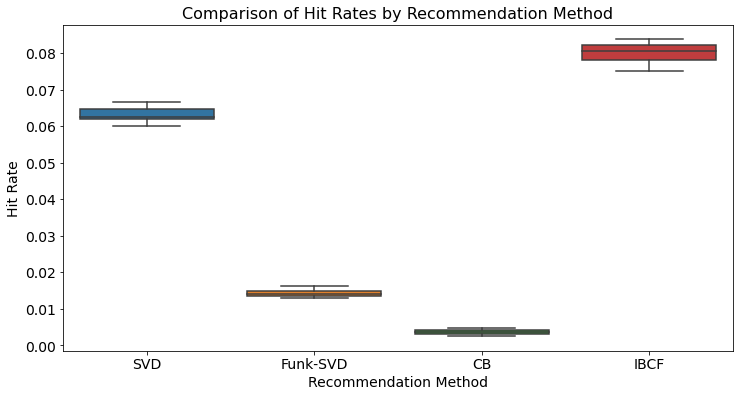

In [28]:
# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Create a box plot to compare hit rates across different recommendation methods
sns.boxplot(data=hitrate_results_df, x="method", y="hit_rate")

# Add a title and axis labels to the plot
plt.title("Comparison of Hit Rates by Recommendation Method", fontsize=16)
plt.xlabel("Recommendation Method", fontsize=14)
plt.ylabel("Hit Rate", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(save_path+"hitrate.png", format='png', dpi=300)

# Display the plot
plt.show()



<Figure size 864x432 with 0 Axes>

<AxesSubplot:xlabel='method', ylabel='time'>

Text(0.5, 1.0, 'Comparison of Time by Recommendation Method')

Text(0.5, 0, 'Recommendation Method')

Text(0, 0.5, 'Time')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'SVD'),
  Text(1, 0, 'Funk-SVD'),
  Text(2, 0, 'CB'),
  Text(3, 0, 'IBCF')])

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

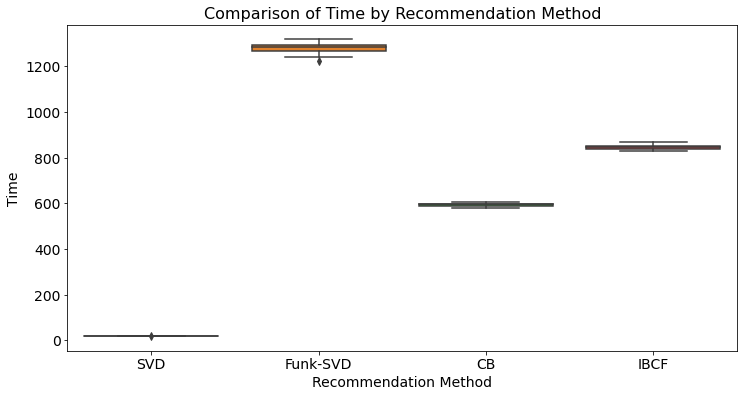

In [29]:
# Set the figure size for the plot
plt.figure(figsize=(12, 6))

# Create a box plot to compare time taken across different recommendation methods
sns.boxplot(data=hitrate_results_df, x="method", y="time")

# Add a title and axis labels to the plot
plt.title("Comparison of Time by Recommendation Method", fontsize=16)
plt.xlabel("Recommendation Method", fontsize=14)
plt.ylabel("Time", fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(save_path+"time.png", format='png', dpi=300)

# Display the plot
plt.show()


- The item-based collaborative filtering (IBCF) method outperforms the others in terms of hit rate, indicating a higher accuracy in capturing user preferences. The content-based method, however, performs the worst, primarily due to its reliance on item features rather than collaborative user information, which limits its ability to generalize beyond user-specific interests.

- The SVD-based method achieves the highest efficiency, with significantly lower computation times compared to the other techniques. Funk-SVD, due to its iterative optimization process, exhibits the longest runtime. The content-based and IBCF methods fall between these two, with moderate time requirements.